# Mini-Challenge DEL: Hyperparameter Tuning und Model Evaluation

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

import torchvision.models as models
from torchvision.models import ResNet18_Weights

import wandb

## Schritt 1: Auswahl des Tasks und des Datensatzes
Für diese Mini-Challenge habe ich mich für einen klassischen **Image Classification Task** entschieden. Ziel ist es, ein Modell zu trainieren, das Bilder korrekt einer von zehn Klassen zuordnet.

Als Datensatz verwende ich **CIFAR-10**, einen etablierten und überschaubaren Datensatz für Bildklassifikation. Der Datensatz enthält **60.000 Farbbilder** in der Grösse 32x32 Pixel, aufgeteilt in zehn Klassen wie Frosch, Hund, Auto oder Flugzeug. Die Daten sind bereits in **Trainings- und Testdaten** aufgeteilt (50.000 / 10.000) und eignen sich besonders gut für schnelle Experimente und den Vergleich verschiedener Modell- und Trainingseinstellungen.

Die Wahl fiel auf CIFAR-10, weil:
- der Datensatz kompakt genug ist, um viele Experimente in kurzer Zeit durchzuführen,
- die Klassifikationsaufgabe realistisch und gut verständlich ist,
- er sich hervorragend eignet, um verschiedene CNN-Architekturen und Trainingsstrategien zu evaluieren,
- und weil er häufig in der Literatur und Lehre verwendet wird, was Vergleiche mit anderen Methoden erleichtert.

Die Entscheidung für diesen Task und Datensatz wurde mit dem Fachcoach abgesprochen und genehmigt.

## Schritt 2: Daten kennenlernen und Preprocessing

Um ein besseres Verständnis für die Daten zu bekommen, wurde im zweiten Schritt eine explorative Analyse des CIFAR-10 Trainingsdatensatzes durchgeführt. Der Fokus lag dabei auf der Klassenverteilung, der visuellen Kontrolle der Bilder, der statistischen Verteilung der Pixelwerte pro Farbkanal sowie dem anschliessenden Preprocessing für das Modelltraining.

In [3]:
transform_eda = ToTensor()
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform_eda)
train_loader_eda = DataLoader(cifar10_train, batch_size=64, shuffle=False)

print(f"Anzahl Trainingsbeispiele: {len(cifar10_train)}")
print(f"Klassen: {cifar10_train.classes}")

Anzahl Trainingsbeispiele: 50000
Klassen: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Klassenverteilung

Der CIFAR-10 Datensatz besteht aus insgesamt 50.000 Trainingsbildern, gleichmässig verteilt auf 10 Klassen. Jede Klasse ist mit genau 5.000 Bildern vertreten. Dies wurde durch Auszählen der Labels bestätigt. Eine gleichmässige Verteilung ist wichtig, da sie bedeutet, dass das Modell keine Klasse bevorzugt behandeln muss, was eine faire und robuste Klassifikation ermöglicht.

Die folgende Grafik zeigt die Verteilung der Klassen im Trainingsset:

airplane  : 5000
automobile: 5000
bird      : 5000
cat       : 5000
deer      : 5000
dog       : 5000
frog      : 5000
horse     : 5000
ship      : 5000
truck     : 5000


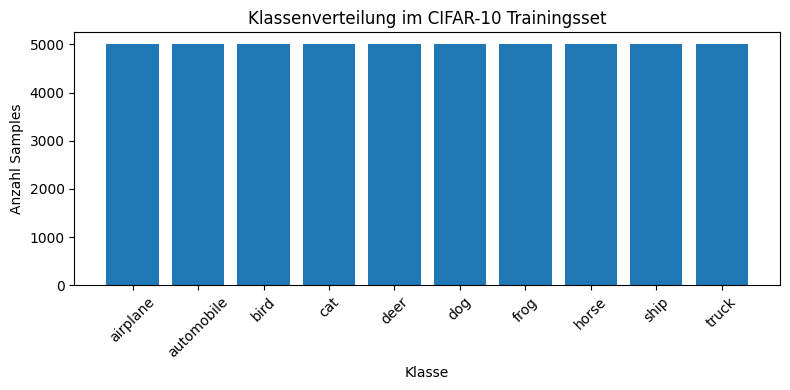

In [4]:
# Gedanken: Wir zählen die Anzahl der Beispiele pro Klasse, um die Balance zu bewerten.
class_counts = [0] * len(cifar10_train.classes)
for _, label in cifar10_train:
    class_counts[label] += 1

for cls, count in zip(cifar10_train.classes, class_counts):
    print(f"{cls:10s}: {count}")

# Bar-Plot der Verteilung\import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(cifar10_train.classes, class_counts)
plt.title('Klassenverteilung im CIFAR-10 Trainingsset')
plt.xlabel('Klasse')
plt.ylabel('Anzahl Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visuelle Inspektion der Daten

Zur qualitativen Kontrolle wurden jeweils ein Beispielbild pro Klasse visualisiert. Dadurch lässt sich überprüfen, ob die Bilddaten korrekt geladen wurden und ob der Inhalt pro Klasse visuell unterscheidbar ist.

In [5]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

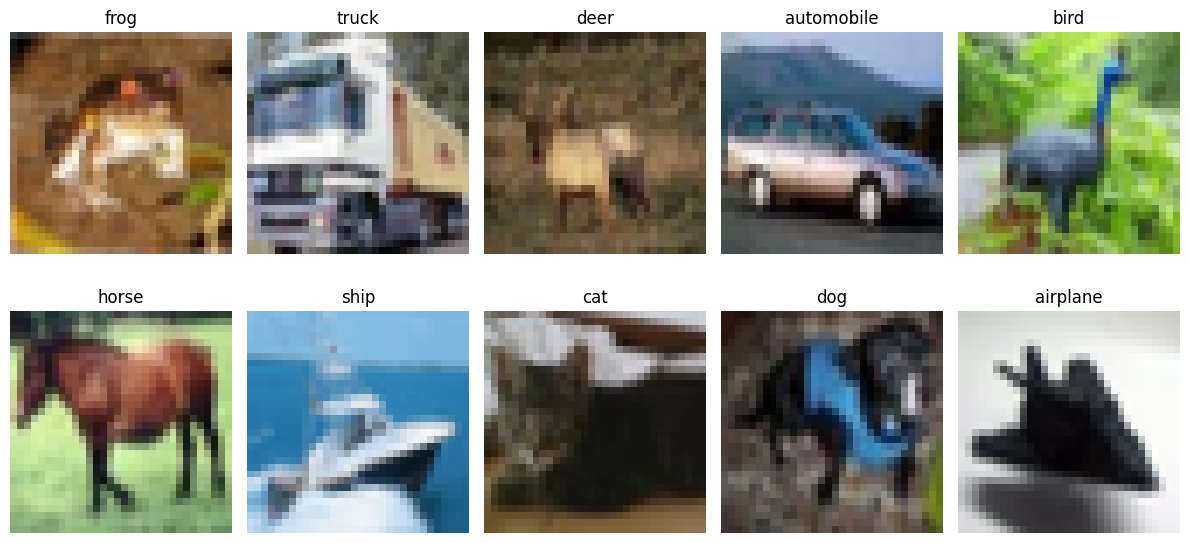

In [6]:
grid_imgs = []
grid_titles = []
seen = {i: False for i in range(len(cifar10_train.classes))}
for img, label in cifar10_train:
    if not seen[label]:
        grid_imgs.append(img)
        grid_titles.append(cifar10_train.classes[label])
        seen[label] = True
    if all(seen.values()):
        break

# Darstellung
plt.figure(figsize=(12,6))
for i, (img, title) in enumerate(zip(grid_imgs, grid_titles)):
    plt.subplot(2, 5, i+1)
    imshow(img, title)
plt.tight_layout()
plt.show()

Die Bilder bestehen aus RGB-Kanälen mit einer Auflösung von 32x32 Pixeln, was vergleichsweise klein ist. Trotz der geringen Auflösung lassen sich die Bildinhalte gut erkennen.

### Analyse der Pixelwertverteilungen

Anhand von Histogrammen wurden die Verteilungen der Pixelwerte für jeden Farbkanal (Rot, Grün, Blau) analysiert. Dabei wurde eine zufällige Stichprobe von 1.000 Bildern verwendet. Die Ergebnisse zeigen eine breite Streuung der Werte über den gesamten Wertebereich, was auf eine gesunde Varianz in den Bildern hindeutet.

Diese Analyse hilft bei der Entscheidung, ob eine Normalisierung sinnvoll ist – was der Fall ist, da dies die Konvergenz des Trainings verbessern kann.

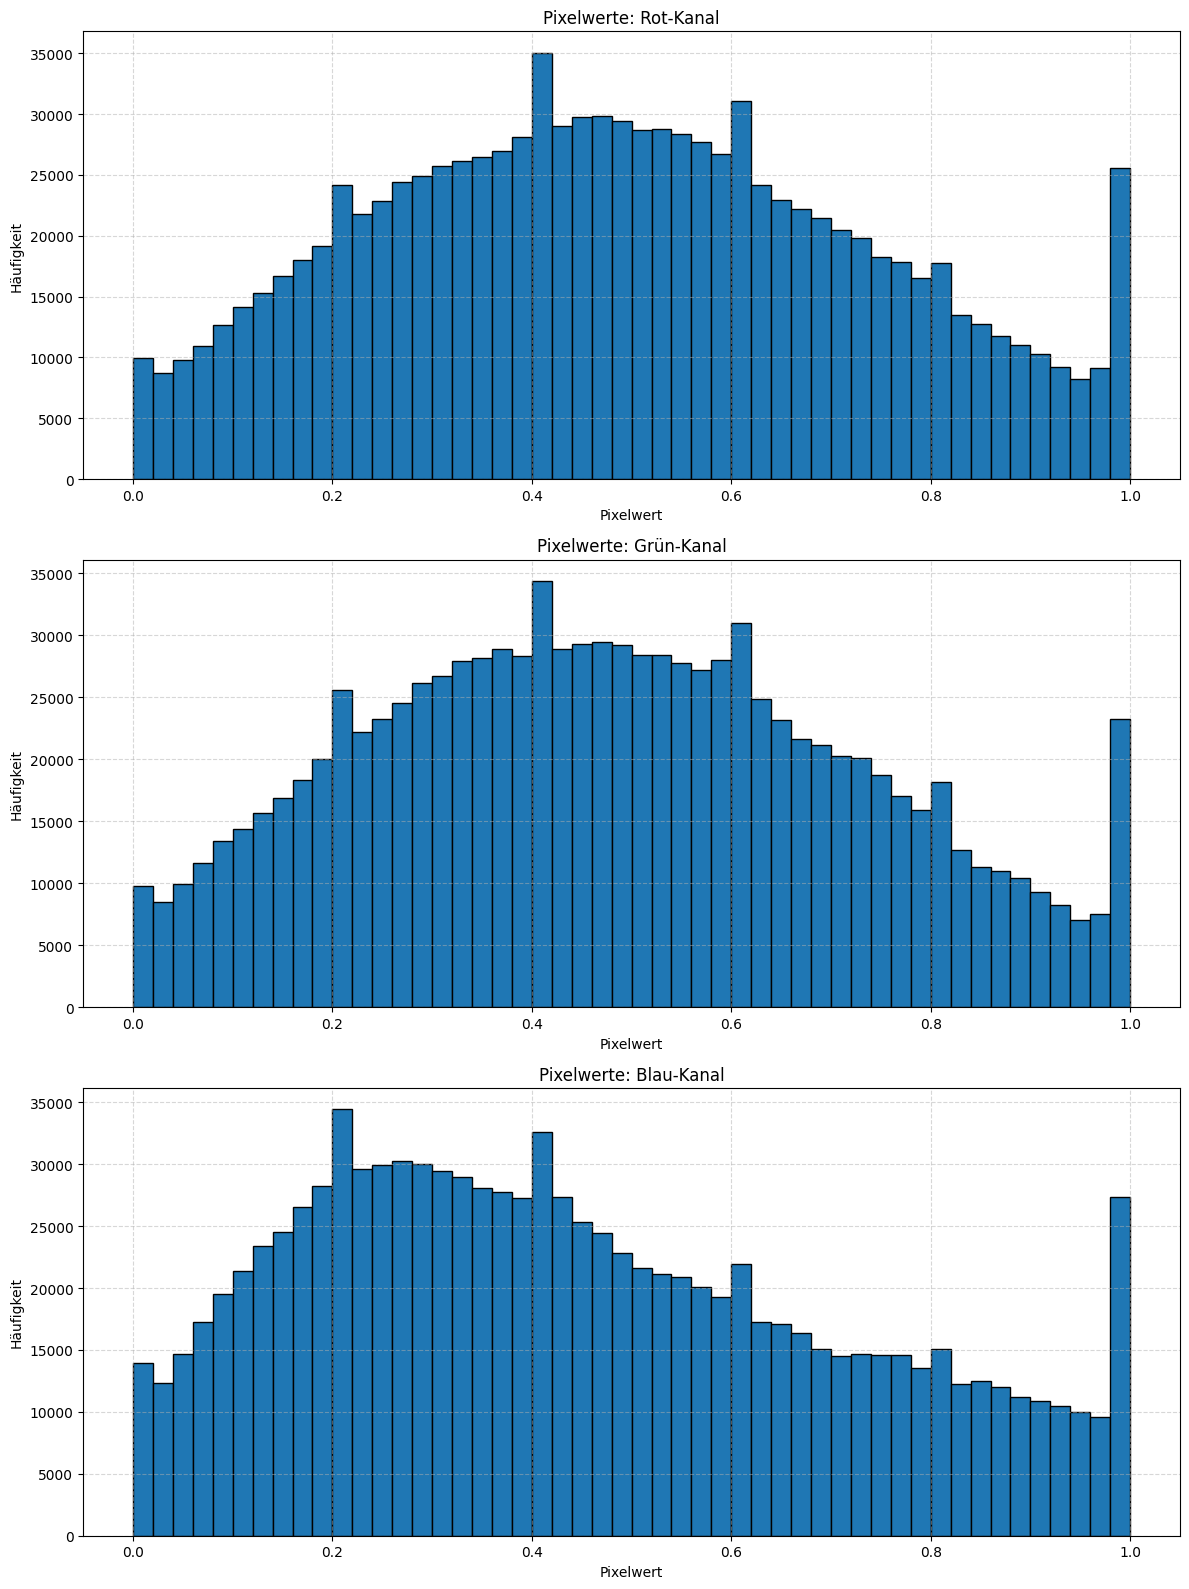

In [7]:
# Kanalweise Pixelwerte sammeln
to_collect = {'Rot': [], 'Grün': [], 'Blau': []}
for i in range(1000):
    img, _ = cifar10_train[i]
    to_collect['Rot'].append(img[0].view(-1))
    to_collect['Grün'].append(img[1].view(-1))
    to_collect['Blau'].append(img[2].view(-1))

# Zusammenführen der Pixelwerte pro Kanal
pixels = {chan: torch.cat(vals).numpy() for chan, vals in to_collect.items()}

# Plot in separaten Subplots
fig, axes = plt.subplots(3, 1, figsize=(12,16))
for ax, (chan, data) in zip(axes, pixels.items()):
    ax.hist(data, bins=50, edgecolor='black')
    ax.set_title(f'Pixelwerte: {chan}-Kanal')
    ax.set_xlabel('Pixelwert')
    ax.set_ylabel('Häufigkeit')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Preprocessing-Schritte

Für ein stabiles Training wurden die Bilder normalisiert. Dazu wurden zunächst die kanalspezifischen Mittelwerte und Standardabweichungen auf dem Trainingsset berechnet:

- **Mean**: [0.4914, 0.4822, 0.4465]
- **Standardabweichung**: [0.2470, 0.2435, 0.2616]

In [8]:
loader_stats = DataLoader(cifar10_train, batch_size=5000, shuffle=False, num_workers=2)
# Ein Batch enthält 5000 Bilder (d.h. 10 Elemente für 50000 Bilder)
all_means = []
all_stds  = []
for imgs, _ in loader_stats:
    # imgs-Form: (Batch, Channels, H, W)
    all_means.append(imgs.mean(dim=[0,2,3]))
    all_stds.append(imgs.std(dim=[0,2,3]))
mean = torch.stack(all_means).mean(dim=0)
std  = torch.stack(all_stds).mean(dim=0)
print(f"Berechnete mean: {mean.tolist()}")
print(f"Berechnete std : {std.tolist()}")

Berechnete mean: [0.49139919877052307, 0.4821583330631256, 0.446530818939209]
Berechnete std : [0.247023344039917, 0.24347808957099915, 0.2615787386894226]


Diese Werte wurden dann zur Normalisierung der Eingabedaten verwendet. Die Normalisierung bringt die Daten aller Kanäle auf vergleichbare Skalen und beschleunigt dadurch das Training.

Auch für die Validierungs- und Testdaten wird dieselbe Normalisierung verwendet, um Konsistenz sicherzustellen.

In [9]:
# Standardwerte für CIFAR-10
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("Preprocessing-Transforms sind definiert.")

Preprocessing-Transforms sind definiert.


Mit diesen vorbereitenden Schritten ist der Datensatz nun optimal für die Modellierung vorbereitet.

### Aufteilung in Trainings-, Validierungs- und Testdaten

Der Original-CIFAR-10 Datensatz liefert 50.000 Trainingsbilder und 10.000 Testbilder. Um auch eine Validierung während des Trainings zu ermöglichen, wurde ein Teil des Trainingssets als **Validierungsmenge** abgetrennt – in exakt derselben Grösse wie das Testset (10.000 Bilder). Dabei kam ein **Stratified Split** zum Einsatz, sodass die Klassenverteilung in allen drei Splits erhalten bleibt.

Die Klassenverteilung wurde für die neuen Splits erneut überprüft. Dank des stratified split ist sichergestellt, dass alle Klassen auch im **Train-, Val- und Test-Set gleichmässig vertreten** sind.

In [ ]:
# Gesamtes Dataset laden
train_base = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_ds = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
) 

# Targets extrahieren
targets = train_base.targets

# Val-Set in Grösse des Test-Sets abtrennen
val_size = len(test_ds)
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
train_idx, val_idx = next(sss.split(
    np.zeros(len(train_base.targets)), train_base.targets
))

train_ds = Subset(train_base, train_idx)
val_ds   = Subset(train_base, val_idx)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,    batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")
print("Klassenverteilung je Split:")

# Labels extrahieren
train_lbls = [train_base.targets[i] for i in train_ds.indices]
val_lbls   = [train_base.targets[i] for i in val_ds.indices]
test_lbls  = test_ds.targets

# Anzahl Klassen
num_classes = len(train_base.classes)

# Ausgabe
for name, lbls in [("Train", train_lbls), ("Val", val_lbls), ("Test", test_lbls)]:
    counts = np.bincount(lbls, minlength=num_classes)
    print(f"  {name}: {counts.tolist()}")

Train/Val/Test sizes: 40000/10000/10000
Klassenverteilung je Split:
  Train: [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
  Val: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
  Test: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Die folgende Grafik zeigt die Verteilung der Klassen in allen drei Splits:

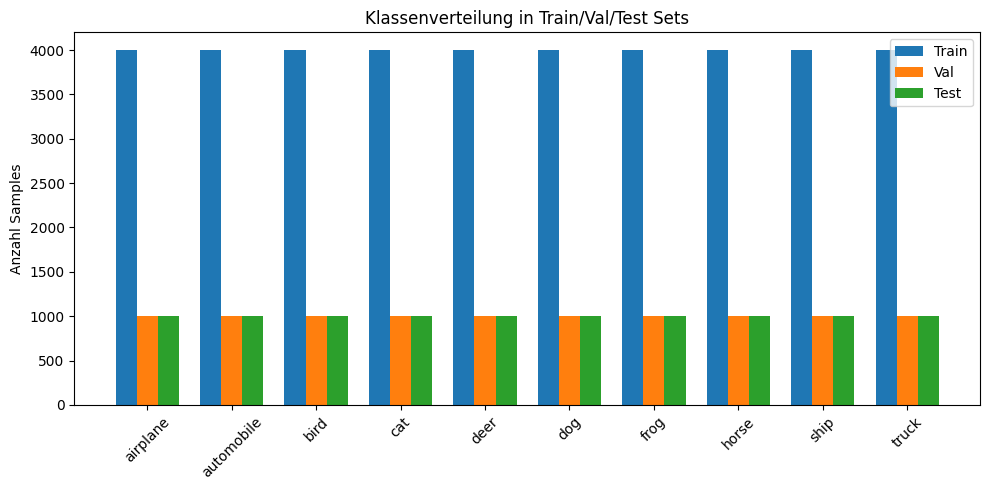

In [11]:
# Labels extrahieren
train_labels = [label for _, label in train_ds]
val_labels   = [label for _, label in val_ds]
test_labels  = [label for _, label in test_ds]

# Klassenliste (10 bei CIFAR-10)
classes = train_base.classes

# Pro Klasse zählen
counts_train = [Counter(train_labels)[i] for i in range(len(classes))]
counts_val   = [Counter(val_labels)[i]   for i in range(len(classes))]
counts_test  = [Counter(test_labels)[i]  for i in range(len(classes))]

# Gruppiertes Balkendiagramm
x     = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, counts_train, width, label='Train')
ax.bar(x,         counts_val,   width, label='Val')
ax.bar(x + width, counts_test,  width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.set_ylabel('Anzahl Samples')
ax.set_title('Klassenverteilung in Train/Val/Test Sets')
ax.legend()

plt.tight_layout()
plt.show()

Mit diesen vorbereitenden Massnahmen ist der Datensatz vollständig analysiert und **modellbereit aufbereitet**. Die nächste Phase besteht nun im Aufbau und Training eines Basismodells.

## Schritt 3: Aufbau des Basismodells und Trainingsfunktionalität

In diesem Schritt wurde ein erstes **Convolutional Neural Network (CNN)** als Basismodell implementiert, das für die Bildklassifikation auf dem CIFAR-10 Datensatz geeignet ist. Zusätzlich wurde die **Trainingspipeline** in PyTorch entwickelt, eine erste **Evaluation** durchgeführt sowie ein **Sanity Check durch Overfitting auf ein einzelnes Bild** vorgenommen. Die Experimente wurden mit Hilfe der MLOps-Plattform **Weights & Biases (W&B)** überwacht und protokolliert.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Architektur des Basismodells

Das Basismodell besteht aus zwei Convolutional-Blöcken gefolgt von einer Flattening-Schicht und zwei Fully-Connected-Layern:

- **conv1**: 3×32×32 → 32×32×32
- **MaxPooling**: 32×32×32 → 32×16×16
- **conv2**: 32×16×16 → 64×16×16
- **MaxPooling**: 64×16×16 → 64×8×8
- **Flatten**: 64×8×8 = 4096 → Dense 128 → Dense 10 Klassen

Diese Architektur ist bewusst einfach gehalten, um als Vergleichsbasis für spätere Varianten zu dienen. Sie ist ausreichend tief, um Muster zu lernen, aber nicht so komplex, dass Overfitting dominiert.

In [13]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [14]:
num_classes = len(train_base.classes)
model = BaselineCNN(num_classes).to(device)
print(model)

BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Trainings- und Evaluationsfunktionen

Zwei zentrale Funktionen wurden implementiert:
- `train_one_epoch`: Training auf einem Datensatz
- `eval_one_epoch`: Validierung ohne Gradientenberechnung

Beide Funktionen berechnen den Loss und die Accuracy pro Epoche und loggen die Ergebnisse optional nach W&B.

Die Haupttrainingsfunktion `train_model` trainiert über mehrere Epochen und speichert Verlauf und Leistung.

Mit der Funktion `compute_metrics` werden nach dem Training zusätzliche Klassifikationsmetriken berechnet:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score (alle Makro-gewichtet)**

Diese Metriken geben ein differenzierteres Bild der Modellleistung, besonders bei Mehrklassenproblemen wie CIFAR-10.

In [15]:
def train_one_epoch(model, loader, criterion, optimizer, epoch=None, log_to_wandb=True):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds    = outputs.max(1)
        correct    += (preds == labels).sum().item()
        total      += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and epoch is not None:
        wandb.log({
            "train_loss": epoch_loss,
            "train_accuracy": epoch_acc,
            "epoch": epoch
        })
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, epoch=None, log_to_wandb=True, split_name="val"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds     = outputs.max(1)
            correct      += (preds == labels).sum().item()
            total        += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and epoch is not None:
        wandb.log({
            f"{split_name}_loss": epoch_loss,
            f"{split_name}_accuracy": epoch_acc,
            "epoch": epoch
        })
    return epoch_loss, epoch_acc


def train_model(
    model, train_loader, val_loader,
    criterion, optimizer, epochs, device
):
    model.to(device)
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    for ep in range(1, epochs+1):
        tl, ta = train_one_epoch(model, train_loader, criterion,
                                 optimizer, epoch=ep)
        vl, va = eval_one_epoch(model,  val_loader,   criterion,
                                epoch=ep, split_name="val")
        train_losses.append(tl); train_accs.append(ta)
        val_losses.append(vl);   val_accs.append(va)
        print(f"Ep {ep}: Tr L={tl:.4f}, A={ta:.1f}% | Val L={vl:.4f}, A={va:.1f}%")

    return model, train_losses, train_accs, val_losses, val_accs

def compute_metrics(model, loader, log_to_wandb=True, split_name="test"):
    """
    Berechnet Precision, Recall, F1 und Accuracy auf dem gesamten Loader.
    Loggt test_accuracy, test_precision und test_recall in W&B, wenn log_to_wandb=True.
    
    Args:
        model (torch.nn.Module): dein trainiertes Modell
        loader: DataLoader für Test/Val
        log_to_wandb (bool): ob die Metriken in W&B gespeichert werden
        split_name (str): Prefix für die W&B-Keys, z.B. "test" oder "val"
    
    Returns:
        precision (float), recall (float), f1 (float), accuracy (float)
    """
    all_lbls, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outs = model(imgs)
            _, preds = outs.max(1)
            all_lbls.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())

    # Klassische Metriken
    precision = precision_score(all_lbls, all_preds, average="macro")
    recall    = recall_score(all_lbls, all_preds, average="macro")
    f1        = f1_score(all_lbls, all_preds, average="macro")
    # Accuracy selbst berechnen
    accuracy  = 100.0 * sum(int(p==l) for p, l in zip(all_preds, all_lbls)) / len(all_lbls)

    # Logging in W&B
    if log_to_wandb:
        wandb.log({
            f"{split_name}_accuracy":  accuracy,
            f"{split_name}_precision": precision,
            f"{split_name}_recall":    recall,
            f"{split_name}_f1":    f1
        })

    return precision, recall, f1, accuracy

def get_number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Sanity Check: Overfitting auf ein Sample

Vor dem eigentlichen Training wurde ein Sanity Check durchgeführt, bei dem versucht wurde, ein einzelnes Bild korrekt zu lernen. Dieser Test dient dazu sicherzustellen, dass der Lernprozess korrekt funktioniert (Forward/Backward + Optimizer + Loss).

In [15]:
# Gedanken: Überprüfen, ob das Modell ein einzelnes Sample komplett lernen kann (sanity check).
ov_model = BaselineCNN(num_classes).to(device)
criterion_ov = nn.CrossEntropyLoss()
optimizer_ov = optim.SGD(ov_model.parameters(), lr=0.01, momentum=0.9)

# Ein Sample aus dem Trainingsset
sample_img, sample_lbl = train_ds[0]
sample_img = sample_img.unsqueeze(0).to(device)
sample_lbl = torch.tensor([sample_lbl], dtype=torch.long).to(device)

print(">>> Single-Sample Overfitting Test:")
for epoch in range(1, 21):
    ov_model.train()
    optimizer_ov.zero_grad()
    out   = ov_model(sample_img)
    loss  = criterion_ov(out, sample_lbl)
    loss.backward()
    optimizer_ov.step()
    _, pred = out.max(1)
    acc     = 100 * (pred == sample_lbl).float().item()
    print(f"Epoch {epoch:02d}: Loss={loss.item():.4f}, Acc={acc:.1f}%")

>>> Single-Sample Overfitting Test:


Epoch 01: Loss=2.2441, Acc=0.0%
Epoch 02: Loss=1.9808, Acc=100.0%
Epoch 03: Loss=1.6086, Acc=100.0%
Epoch 04: Loss=1.0450, Acc=100.0%
Epoch 05: Loss=0.3506, Acc=100.0%
Epoch 06: Loss=0.0329, Acc=100.0%
Epoch 07: Loss=0.0012, Acc=100.0%
Epoch 08: Loss=0.0000, Acc=100.0%
Epoch 09: Loss=0.0000, Acc=100.0%
Epoch 10: Loss=0.0000, Acc=100.0%
Epoch 11: Loss=0.0000, Acc=100.0%
Epoch 12: Loss=0.0000, Acc=100.0%
Epoch 13: Loss=0.0000, Acc=100.0%
Epoch 14: Loss=0.0000, Acc=100.0%
Epoch 15: Loss=0.0000, Acc=100.0%
Epoch 16: Loss=0.0000, Acc=100.0%
Epoch 17: Loss=0.0000, Acc=100.0%
Epoch 18: Loss=0.0000, Acc=100.0%
Epoch 19: Loss=0.0000, Acc=100.0%
Epoch 20: Loss=0.0000, Acc=100.0%


Das Modell konnte das Bild innerhalb weniger Epochen perfekt lernen – ein gutes Zeichen für einen funktionierenden Trainingsprozess.

Diese Parameter werden als Grundlage dienen.

In [16]:
# Hyperparameter
epochs = 15
batch_size = 32
learning_rate = 0.001
project_name = "image-classification"
run_name = "baseline_cnn"

In [17]:
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "BaselineCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oliver-pejic (oliver-pejic-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
baseline_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(baseline_model, log="all", log_freq=10)

baseline_model, bl_tr_losses, bl_tr_accs, bl_val_losses, bl_val_accs = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer, epochs, device
)

bl_prec, bl_rec, bl_f1, bl_test_acc = compute_metrics(
    baseline_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(baseline_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.7799, A=36.0% | Val L=1.4740, A=46.6%
Ep 2: Tr L=1.3777, A=50.5% | Val L=1.3000, A=54.5%
Ep 3: Tr L=1.2142, A=57.0% | Val L=1.1710, A=59.0%
Ep 4: Tr L=1.0889, A=61.6% | Val L=1.0898, A=61.8%
Ep 5: Tr L=0.9892, A=65.3% | Val L=1.0339, A=64.3%
Ep 6: Tr L=0.9037, A=68.4% | Val L=0.9840, A=66.1%
Ep 7: Tr L=0.8269, A=71.0% | Val L=0.9143, A=68.2%
Ep 8: Tr L=0.7614, A=73.3% | Val L=0.9354, A=68.0%
Ep 9: Tr L=0.6998, A=75.7% | Val L=0.9073, A=68.9%
Ep 10: Tr L=0.6410, A=77.7% | Val L=0.8821, A=69.8%
Ep 11: Tr L=0.5814, A=79.8% | Val L=0.8714, A=70.6%
Ep 12: Tr L=0.5229, A=81.9% | Val L=0.8750, A=71.0%
Ep 13: Tr L=0.4679, A=83.8% | Val L=0.8998, A=71.0%
Ep 14: Tr L=0.4093, A=85.9% | Val L=0.9283, A=70.8%
Ep 15: Tr L=0.3603, A=87.7% | Val L=0.9349, A=71.5%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model--VmlldzoxMzE2OTkxMg" style="border:none;height:1024px;width:100%">

### 5-Fold Cross-Validation

Zusätzlich zum regulären Train/Val/Test-Split wurde ein 5-faches Cross-Validation-Verfahren (KFold) durchgeführt, um die Stabilität und Generalisierungsfähigkeit des Basismodells besser einzuschätzen.

**Vorgehen**:
- Der Datensatz wurde mit KFold(n_splits=5, shuffle=True, random_state=42) aufgeteilt.
- Pro Fold wurde ein frisches Modell über 5 kurze Epochen trainiert und auf dem jeweiligen Validierungssplit evaluiert.
- Ziel war es, pro Fold die **Validation Accuracy** zu bestimmen.
- Nach jedem Fold wurde der GPU-Speicher aktiv bereinigt, um Ressourcen zu schonen.

In [19]:
# 2) KFold mit Shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accs = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(targets), 1):
    print(f">>> Fold {fold}")

    # 3) Subsets und DataLoader (nur Norm-Transform)
    train_ds = Subset(train_base, tr_idx)
    val_ds   = Subset(train_base, va_idx)
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # 4) Frisches Modell + Optimizer
    m_cv  = BaselineCNN(num_classes).to(device)
    opt   = optim.SGD(m_cv.parameters(), lr=learning_rate, momentum=0.9)
    crit  = nn.CrossEntropyLoss()

    # 5) Kurzes Training & Evaluation pro Fold
    for _ in range(5):
        train_one_epoch(m_cv, train_ld, crit, opt, log_to_wandb=False)
    _, acc = eval_one_epoch(m_cv, val_ld, crit, log_to_wandb=False, split_name="cv")
    fold_accs.append(acc)
    print(f"Fold {fold}: Val Acc = {acc:.2f}%")

    # 6) Aufräumen, damit kein GPU-Speicher hängen bleibt
    del m_cv, opt, crit, train_ld, val_ld
    torch.cuda.empty_cache()

# 7) Zusammenfassung der CV-Ergebnisse
mean_acc = np.mean(fold_accs)
std_acc  = np.std(fold_accs)
print(f"5-Fold CV Results: Mean = {mean_acc:.2f}%, Std = {std_acc:.2f}%")

>>> Fold 1


Fold 1: Val Acc = 64.39%
>>> Fold 2
Fold 2: Val Acc = 64.12%
>>> Fold 3
Fold 3: Val Acc = 63.69%
>>> Fold 4
Fold 4: Val Acc = 65.71%
>>> Fold 5
Fold 5: Val Acc = 63.85%
5-Fold CV Results: Mean = 64.35%, Std = 0.72%


Die folgende Grafik zeigt die Validierungsgenauigkeit pro Fold sowie den Mittelwert:

Die Mittelwert der Validierungsgenauigkeit liegt bei 59.53 %, mit einer sehr geringen Standardabweichung von 0.77 % – ein Zeichen für ein robustes und stabil lernendes Modell auf unterschiedlichen Subsets.


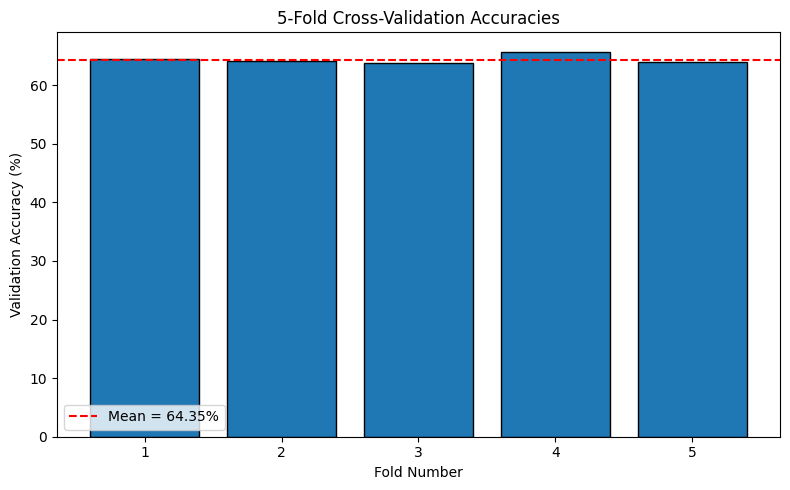

In [20]:
# Balkendiagramm der Fold-Accuracies
plt.figure(figsize=(8,5))
plt.bar(range(1,6), fold_accs, edgecolor='black')
plt.axhline(y=mean_acc, linestyle='--', color='red', label=f'Mean = {mean_acc:.2f}%')
plt.title('5-Fold Cross-Validation Accuracies')
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy (%)')
plt.xticks(range(1,6))
plt.legend()
plt.tight_layout()
plt.show()

Trotz der sauberen Umsetzung ist anzumerken, dass **Cross-Validation bei sehr grossen Datensätzen wie CIFAR-10** in der Praxis **nicht notwendig** ist. Die Stichprobe ist mit 50.000 Bildern gross genug, sodass ein einmaliger Val/Test-Split genügt, um die Generalisierungsfähigkeit realistisch zu bewerten.

Cross-Validation wird vor allem dann verwendet, wenn:
- **nur wenig Trainingsdaten zur Verfügung stehen**, oder
- eine **besonders präzise Schätzung der Modellunsicherheit** erforderlich ist.

In unserem Fall war der 5-Fold-Test dennoch nützlich, um zu bestätigen, dass die Modellarchitektur auf verschiedenen Datenaufteilungen **ähnlich gute Ergebnisse liefert**.

---

## Schritt 4: Hyperparameter Tuning

In diesem Schritt formulieren wir 10 Hypothesen aus den vorgegebenen Gruppen, führen Experimente durch und reflektieren die Ergebnisse.

### Hypothese 1 – Reduzierte Lernrate

#### Hypothese:

Wenn die Lernrate von 0.001 (Baseline-Modell) auf 0.0001 reduziert wird, erwarten wir einen langsamen, aber stabilen Lernverlauf. Kleinere Lernraten führen dazu, dass das Modell kleinere Schritte im Fehlerraum macht, wodurch das Risiko verringert wird, dass es in schlechte lokale Minima springt oder instabile Schwankungen im Loss-Verlauf auftreten.

Allerdings kann ein zu kleiner Lernschritt auch dazu führen, dass das Modell nicht vollständig konvergiert, insbesondere wenn die Anzahl der Trainings-Epochen begrenzt ist. In diesem Experiment wird deshalb die Anzahl Epochen auf 60 erhöht.

*Referenz:* [The Learning Rate: A Hyperparameter That Matters](https://mohitmishra786687.medium.com/the-learning-rate-a-hyperparameter-that-matters-b2f3b68324ab)
Dort wird beschrieben, dass eine zu kleine Lernrate zwar zu stabileren, aber deutlich langsameren Lernprozessen führt, was in der Praxis eine Herausforderung sein kann, wenn die Trainingszeit begrenzt ist.

#### Experiment
- Lernrate: 0.0001 (statt 0.001)
- Epochen: 60 (statt 15)
- W&B Run: "lower_lr"

Das Ziel ist es, die Lernkurven sowie die finalen Testmetriken mit dem Baseline-Modell zu vergleichen, um die Auswirkung der kleineren Lernrate zu beurteilen.

In [21]:
lr_small = 0.0001
epochs_lr = 60

# W&B Init für Hypothese 1
wandb.init(
    project=project_name,
    name="lower_lr",
    config={"hypothesis": "lower_lr",
            "learning_rate": lr_small,
            "epochs": epochs_lr,
            "batch_size": batch_size}
)

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇██████
val_loss,█▆▄▄▃▂▁▂▁▁▁▁▁▂▂
epoch,15


In [22]:
lower_lr_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lower_lr_model.parameters(), lr=lr_small, momentum=0.9)
wandb.watch(lower_lr_model, log="all", log_freq=10)

lower_lr_model, lower_lr_tr_losses, lower_lr_tr_accs, lower_lr_val_losses, lower_lr_val_accs = train_model(
    lower_lr_model, train_loader, val_loader, criterion, optimizer, epochs_lr, device
)

lower_lr_prec, lower_lr_rec, lower_lr_f1, lower_lr_test_acc = compute_metrics(
    lower_lr_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(lower_lr_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=2.2458, A=20.1% | Val L=2.1576, A=24.9%
Ep 2: Tr L=2.0402, A=28.9% | Val L=1.9398, A=31.0%
Ep 3: Tr L=1.8710, A=34.4% | Val L=1.8189, A=35.9%
Ep 4: Tr L=1.7724, A=38.1% | Val L=1.7384, A=39.3%
Ep 5: Tr L=1.6976, A=40.6% | Val L=1.6651, A=41.9%
Ep 6: Tr L=1.6265, A=43.0% | Val L=1.6024, A=43.9%
Ep 7: Tr L=1.5591, A=45.4% | Val L=1.5365, A=46.3%
Ep 8: Tr L=1.4978, A=47.4% | Val L=1.4786, A=48.3%
Ep 9: Tr L=1.4483, A=48.8% | Val L=1.4378, A=48.8%
Ep 10: Tr L=1.4063, A=50.3% | Val L=1.3991, A=50.5%
Ep 11: Tr L=1.3726, A=51.4% | Val L=1.3712, A=51.5%
Ep 12: Tr L=1.3411, A=52.5% | Val L=1.3539, A=52.1%
Ep 13: Tr L=1.3129, A=53.5% | Val L=1.3214, A=53.5%
Ep 14: Tr L=1.2898, A=54.5% | Val L=1.3081, A=54.5%
Ep 15: Tr L=1.2654, A=55.3% | Val L=1.2843, A=55.0%
Ep 16: Tr L=1.2435, A=56.0% | Val L=1.2640, A=55.8%
Ep 17: Tr L=1.2244, A=56.8% | Val L=1.2485, A=56.4%
Ep 18: Tr L=1.2040, A=57.5% | Val L=1.2314, A=57.0%
Ep 19: Tr L=1.1866, A=58.2% | Val L=1.2160, A=57.4%
Ep 20: Tr L=1.1676, A

<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Lower-Learning-Rate-Model--VmlldzoxMzE2OTg0NA" style="border:none;height:1024px;width:100%">

### Hypothese 2 – Gewichtinitialisierung mit Xavier

#### Hypothese

Standardmässig initialisiert PyTorch die Modellgewichte in Convolutional- und Linear-Schichten mit einer gleichverteilten oder normalverteilten Methode. Durch die explizite Anwendung der **Xavier-Initialisierung** `xavier_uniform_` erwarten wir eine **bessere Startverteilung der Gewichte**, was zu einem **stabileren und schnelleren Lernverlauf** führen kann.

Die Xavier-Initialisierung wurde speziell dafür entwickelt, die Varianz der Aktivierungen über viele Schichten hinweg konstant zu halten. Dadurch werden **Exploding oder Vanishing Gradients** reduziert, was insbesondere bei tieferen Netzen relevant ist – aber auch bei kleinen Netzen zu effizienteren Lernschritten führen kann.

*Referenz:* [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

#### Experiment

In diesem Experiment wurden alle Gewichte der Conv2d- und Linear-Schichten im BaselineCNN-Modell mithilfe der xavier_uniform_()-Methode initialisiert.
- Initialisierung: Xavier Uniform für Conv2d und Linear-Layer
- Bias: auf 0 gesetzt
- W&B Run: "xavier_init"

Die restliche Trainingsumgebung blieb identisch zur Baseline, um die Auswirkungen der Initialisierung gezielt zu untersuchen.

In [23]:
def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [24]:
# W&B Init für Hypothese 2
wandb.init(
    project=project_name,
    name="xavier_init",
    config={"hypothesis": "xavier_init",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▃▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████████
train_loss,█▇▆▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▇▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,60


In [25]:
xav_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xav_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(xav_model, log="all", log_freq=10)

xav_model, xav_tr_losses, xav_tr_accs, xav_val_losses, xav_val_accs = train_model(
    xav_model, train_loader, val_loader, criterion, optimizer, epochs, device
)

xav_prec, xav_rec, xav_f1, xav_test_acc = compute_metrics(
    xav_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(xav_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.8122, A=35.4% | Val L=1.5086, A=45.9%
Ep 2: Tr L=1.3872, A=50.4% | Val L=1.3189, A=53.3%
Ep 3: Tr L=1.2305, A=56.2% | Val L=1.1752, A=58.9%
Ep 4: Tr L=1.1110, A=60.9% | Val L=1.1240, A=61.1%
Ep 5: Tr L=1.0149, A=64.3% | Val L=1.0320, A=64.7%
Ep 6: Tr L=0.9327, A=67.4% | Val L=0.9885, A=65.7%
Ep 7: Tr L=0.8596, A=70.1% | Val L=0.9993, A=65.5%
Ep 8: Tr L=0.7952, A=72.4% | Val L=0.9042, A=69.0%
Ep 9: Tr L=0.7370, A=74.5% | Val L=0.9097, A=68.2%
Ep 10: Tr L=0.6797, A=76.4% | Val L=0.9098, A=68.8%
Ep 11: Tr L=0.6209, A=78.3% | Val L=0.9169, A=68.8%
Ep 12: Tr L=0.5649, A=80.4% | Val L=0.9408, A=69.3%
Ep 13: Tr L=0.5083, A=82.5% | Val L=0.9238, A=70.3%
Ep 14: Tr L=0.4516, A=84.4% | Val L=0.9171, A=70.9%
Ep 15: Tr L=0.3960, A=86.4% | Val L=0.9721, A=70.5%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Xavier-Model--VmlldzoxMzE3ODcyNQ" style="border:none;height:1024px;width:100%">

### Hypothese 3 – Erhöhte Modellkomplexität (zusätzlicher Conv-Layer)

#### Hypothese

Durch das Hinzufügen eines weiteren Convolutional-Layers (conv3) in der Netzwerkarchitektur wird die Modelltiefe erhöht. Die Hypothese ist, dass ein tieferes Modell in der Lage ist, komplexere Merkmale in den Bilddaten zu erfassen und dadurch die Trainings- und Testgenauigkeit verbessert.

Tieferere Netzwerke besitzen eine höhere Ausdruckskraft, d. h., sie können feinere Muster lernen. Allerdings kann eine erhöhte Modelltiefe auch zu Overfitting führen, insbesondere wenn keine zusätzlichen Regularisierungstechniken wie Dropout oder BatchNorm eingesetzt werden.

*Referenz:* [3Blue1Brown - Neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

#### Experiment

Ein dritter Convolutional-Layer (conv3) mit 128 Kanälen wurde dem bisherigen BaselineCNN hinzugefügt. Daraus ergibt sich folgende Architektur:
- 3 × Conv2d + ReLU + MaxPool (jeweils)
- Dense-Schichten: 128×4×4 → 256 → 10
- Kein Dropout oder BatchNorm, um den Einfluss der Tiefe isoliert zu untersuchen

Weitere Einstellungen:
- Modell: ExtendedCNN
- W&B Run: "deeper_model"

Die restliche Trainings- und Evaluationspipeline blieb identisch.

In [26]:
class ExtendedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # neues Layer
        self.fc1   = nn.Linear(128 * 4 * 4, 256)  # Achtung: räumliche Dimension halbiert sich dreimal
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(torch.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(x.size(0), -1)                  # [B, 128*4*4]
        x = torch.relu(self.fc1(x))                # [B, 256]
        return self.fc2(x)

In [27]:
wandb.init(
    project=project_name,
    name="deeper_model",
    config={"hypothesis": "deeper_model",
            "model": "ExtendedCNN",
            "learning_rate": learning_rate,
            "epochs": 20,
            "batch_size": batch_size}
)

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▆▇▇▇▇████
val_loss,█▆▄▄▂▂▂▁▁▁▁▁▁▁▂
epoch,15


In [28]:
extended_model = ExtendedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(extended_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(extended_model, log="all", log_freq=10)

extended_model, extended_tr_losses, extended_tr_accs, extended_val_losses, extended_val_accs = train_model(
    extended_model, train_loader, val_loader, criterion, optimizer, 20, device
)

extended_prec, extended_rec, extended_f1, extended_test_acc = compute_metrics(
    extended_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(extended_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.9659, A=29.2% | Val L=1.6837, A=38.5%
Ep 2: Tr L=1.5441, A=44.2% | Val L=1.4822, A=46.2%
Ep 3: Tr L=1.3655, A=50.7% | Val L=1.3072, A=54.1%
Ep 4: Tr L=1.2250, A=56.6% | Val L=1.2495, A=55.3%
Ep 5: Tr L=1.1043, A=60.8% | Val L=1.0764, A=62.2%
Ep 6: Tr L=1.0036, A=64.6% | Val L=1.0290, A=64.0%
Ep 7: Tr L=0.9202, A=67.9% | Val L=1.0449, A=63.5%
Ep 8: Tr L=0.8437, A=70.6% | Val L=0.9036, A=68.9%
Ep 9: Tr L=0.7724, A=73.1% | Val L=0.8880, A=69.6%
Ep 10: Tr L=0.7084, A=75.2% | Val L=0.8494, A=71.0%
Ep 11: Tr L=0.6517, A=77.2% | Val L=0.8166, A=72.3%
Ep 12: Tr L=0.5889, A=79.5% | Val L=0.8428, A=71.7%
Ep 13: Tr L=0.5348, A=81.5% | Val L=0.8282, A=72.5%
Ep 14: Tr L=0.4787, A=83.4% | Val L=0.8231, A=72.9%
Ep 15: Tr L=0.4264, A=85.3% | Val L=0.8486, A=72.4%
Ep 16: Tr L=0.3710, A=87.1% | Val L=0.8460, A=73.0%
Ep 17: Tr L=0.3218, A=88.8% | Val L=0.8680, A=73.5%
Ep 18: Tr L=0.2715, A=90.7% | Val L=0.9281, A=73.9%
Ep 19: Tr L=0.2228, A=92.4% | Val L=1.0076, A=72.9%
Ep 20: Tr L=0.1830, A

<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Deeper-Model--VmlldzoxMzE3ODc3MQ" style="border:none;height:1024px;width:100%">

### Hypothese 4: Mehr Filter verbessern die Performance

#### Hypothese

Wenn die Anzahl der Filter in den Convolutional Layers erhöht wird, kann das Modell mehr komplexe und diverse Merkmale aus den Bildern extrahieren. Dies sollte die Repräsentationskraft des Netzwerks steigern und zu einer besseren Modellleistung führen. Besonders bei komplexeren Bilddaten kann ein breiteres Feature-Set Vorteile bringen. Ich erwarte daher eine schnellere Verbesserung in der Trainingsgenauigkeit sowie ein höheres Test-F1-Score im Vergleich zum Baseline-Modell.

Mehr Filter erzeugen mehr Feature-Maps, wodurch mehr lokale Muster im Bild parallel gelernt werden können. Dies kann hilfreich sein, wenn das Problem mehr Unterscheidungsmerkmale verlangt. 

*Referenz:* [Convolutional Neural Networks (CNNs / ConvNets)](https://cs231n.github.io/convolutional-networks/#conv)

#### Experiment

Für das Experiment wurde die Anzahl der Filter in beiden Convolutional Layers verdoppelt:
- Conv1: 32 → 64 Filter
- Conv2: 64 → 128 Filter

Die Fully Connected Layer wurde entsprechend an die neue Feature-Map-Grösse angepasst.
- Modellname: FilteredCNN
- W&B Run: "wider_model"

Die restliche Trainings- und Evaluationspipeline blieb identisch.

In [ ]:
class FilteredCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # statt 32 nun 64 Filter
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # statt 64 nun 128 Filter
        self.fc1   = nn.Linear(128 * 8 * 8, 256)  # mehr Feature-Maps, also Grösse anpassen
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 64, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 128, 8, 8]
        x = x.view(x.size(0), -1)                  # [B, 128*8*8]
        x = torch.relu(self.fc1(x))                # [B, 256]
        return self.fc2(x)

In [30]:
# W&B Init für Hypothese 4
wandb.init(
    project=project_name,
    name="wider_model",
    config={"hypothesis": "wider_model",
            "model": "FilteredCNN",
            "learning_rate": learning_rate,
            "epochs": 15,
            "batch_size": batch_size}
)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▃▄▄▆▆▆▇▇▇██████████
val_loss,█▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▂▃▃
epoch,20


In [31]:
filtered_model = FilteredCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filtered_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(filtered_model, log="all", log_freq=10)

filtered_model, filtered_tr_losses, filtered_tr_accs, filtered_val_losses, filtered_val_accs = train_model(
    filtered_model, train_loader, val_loader, criterion, optimizer, 15, device
)

filtered_prec, filtered_rec, filtered_f1, filtered_test_acc = compute_metrics(
    filtered_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(filtered_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.7161, A=38.9% | Val L=1.4127, A=50.0%
Ep 2: Tr L=1.3144, A=53.1% | Val L=1.2907, A=55.7%
Ep 3: Tr L=1.1469, A=59.5% | Val L=1.1023, A=61.1%
Ep 4: Tr L=1.0238, A=63.9% | Val L=1.0637, A=62.7%
Ep 5: Tr L=0.9244, A=67.7% | Val L=0.9798, A=65.7%
Ep 6: Tr L=0.8418, A=70.5% | Val L=0.9087, A=68.2%
Ep 7: Tr L=0.7618, A=73.6% | Val L=0.9001, A=68.7%
Ep 8: Tr L=0.6884, A=76.0% | Val L=0.8980, A=68.8%
Ep 9: Tr L=0.6152, A=78.7% | Val L=0.8780, A=69.4%
Ep 10: Tr L=0.5398, A=81.4% | Val L=0.8437, A=71.5%
Ep 11: Tr L=0.4667, A=84.2% | Val L=0.8820, A=70.8%
Ep 12: Tr L=0.3892, A=86.9% | Val L=0.9245, A=70.3%
Ep 13: Tr L=0.3212, A=89.4% | Val L=0.9312, A=70.9%
Ep 14: Tr L=0.2526, A=91.9% | Val L=0.9695, A=71.2%
Ep 15: Tr L=0.1908, A=94.1% | Val L=1.0325, A=72.0%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Wider-Model--VmlldzoxMzE3ODc5Ng" style="border:none;height:1024px;width:100%">

### Hypothese 5: Grössere Convolution-Kernel (5x5)

#### Hypothese

Durch den Einsatz grösserer Convolutional-Kernel (5x5 statt 3x3) wird ein grösserer Kontextbereich im Bild erfasst. Dies könnte dazu führen, dass das Modell abstraktere Merkmale effizienter extrahieren kann, was die Klassifikationsleistung insbesondere bei komplexeren Objekten verbessern könnte. Allerdings besteht auch die Gefahr, dass durch die breitere Rezeption feinere Details verloren gehen und mehr Overfitting entsteht, da grössere Kernel mehr Parameter erzeugen.

Wir erwarten, dass das Modell schneller an Genauigkeit gewinnt und sich die Trainingsgenauigkeit verbessert. Die Validierungsleistung könnte jedoch entweder leicht steigen (wenn der zusätzliche Kontext hilft) oder stagnieren (wenn Overfitting überwiegt).

*Referenz:* [Convolutional Neural Networks (CNNs / ConvNets)](https://cs231n.github.io/convolutional-networks/#conv)

#### Experiment

- Architektur: kernel_size_5_CNN mit zwei Conv-Layern à 5x5-Kernel
- Modellname: kernel_size_5_CNN
- W&B Run: "kernel5"

Die restliche Trainings- und Evaluationspipeline blieb identisch.

In [17]:
class kernel_size_5_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Padding=2, damit Ausgangsdimension gleich bleibt
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(x.size(0), -1)                 # [B, 64*8*8]
        x = torch.relu(self.fc1(x))               # [B, 128]
        return self.fc2(x)

In [18]:
# W&B Init für Hypothese 5
wandb.init(
    project=project_name,
    name="kernel5",
    config={"hypothesis": "kernel_5x5",
            "model": "kernel_size_5_CNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oliver-pejic (oliver-pejic-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
kernel_5_model = kernel_size_5_CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(kernel_5_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(kernel_5_model, log="all", log_freq=10)

kernel_5_model, kernel_5_tr_losses, kernel_5_tr_accs, kernel_5_val_losses, kernel_5_val_accs = train_model(
    kernel_5_model, train_loader, val_loader, criterion, optimizer, epochs, device
)

kernel_5_prec, kernel_5_rec, kernel_5_f1, kernel_5_test_acc = compute_metrics(
    kernel_5_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(kernel_5_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.7153, A=38.2% | Val L=1.4196, A=49.5%
Ep 2: Tr L=1.3265, A=52.4% | Val L=1.2516, A=56.0%
Ep 3: Tr L=1.1619, A=58.8% | Val L=1.1138, A=60.9%
Ep 4: Tr L=1.0329, A=63.6% | Val L=1.0877, A=61.6%
Ep 5: Tr L=0.9341, A=67.4% | Val L=0.9628, A=67.0%
Ep 6: Tr L=0.8459, A=70.6% | Val L=0.9169, A=68.8%
Ep 7: Tr L=0.7686, A=73.2% | Val L=0.8821, A=69.9%
Ep 8: Tr L=0.6978, A=75.9% | Val L=0.8857, A=70.1%
Ep 9: Tr L=0.6289, A=78.3% | Val L=0.8754, A=69.8%
Ep 10: Tr L=0.5614, A=80.6% | Val L=0.8473, A=70.9%
Ep 11: Tr L=0.4973, A=82.9% | Val L=0.8706, A=71.0%
Ep 12: Tr L=0.4298, A=85.3% | Val L=0.8740, A=71.9%
Ep 13: Tr L=0.3665, A=87.6% | Val L=0.9832, A=70.7%
Ep 14: Tr L=0.3115, A=89.5% | Val L=0.9568, A=71.9%
Ep 15: Tr L=0.2558, A=91.5% | Val L=1.0019, A=71.3%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Kernel-Model--VmlldzoxMzE3ODgxMA" style="border:none;height:1024px;width:100%">

### Hypothese 6: Verwendung von MaxPooling vs. Kein Pooling

#### Hypothese
Wenn auf das zweite Pooling-Layer verzichtet wird, erhöht sich die Modellkapazität, da mehr räumliche Information erhalten bleibt. Dies sollte sich positiv auf die Genauigkeit auswirken – insbesondere bei komplexeren Bildmerkmalen. Gleichzeitig steigt jedoch die Anzahl der Modellparameter stark an, was zu einem höheren Risiko von Overfitting führen kann.

Pooling reduziert die räumliche Auflösung und damit auch die Komplexität der Repräsentation. Wird das zweite Pooling-Layer weggelassen, bleiben mehr Details erhalten, was eine feinere Klassifizierung begünstigen kann. Gleichzeitig führt dies zu einem deutlich grösseren vollvernetzten Layer, was mehr Rechenleistung und Regularisierung erfordert.

*Referenz:* [CS231n Convolutional Neural Networks for Visual Recognition – Stanford](https://cs231n.github.io/convolutional-networks/#pool)

#### Experiment

Architektur: NoPoolingCNN mit zwei Convolutional-Layern, jedoch nur einem MaxPooling-Layer nach der ersten Convolution.

- Modellname: NoPoolingCNN
- W&B Run: "no_pooling"

Die restliche Trainings- und Evaluationspipeline blieb identisch.

In [20]:
class NoPoolingCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # kein Pooling nach conv2
        self.fc1   = nn.Linear(64 * 16 * 16, 128)  # räumliche Dimension bleibt 16×16
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = torch.relu(self.conv2(x))              # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)                  # [B, 64*16*16]
        x = torch.relu(self.fc1(x))                # [B, 128]
        return self.fc2(x)

In [21]:
# W&B Init für Hypothese 6
wandb.init(
    project=project_name,
    name="no_pooling",
    config={"hypothesis": "no_pooling",
            "model": "NoPoolingCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▇▇▇██████
val_loss,█▆▄▄▂▂▁▁▁▁▁▁▃▂▃
epoch,15


In [22]:
no_pooling_model = NoPoolingCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(no_pooling_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(no_pooling_model, log="all", log_freq=10)

no_pooling_model, no_pooling_tr_losses, no_pooling_tr_accs, no_pooling_val_losses, no_pooling_val_accs = train_model(
    no_pooling_model, train_loader, val_loader, criterion, optimizer, epochs, device
)

no_pooling_prec, no_pooling_rec, no_pooling_f1, no_pooling_test_acc = compute_metrics(
    no_pooling_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(no_pooling_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.6730, A=40.2% | Val L=1.4025, A=50.1%
Ep 2: Tr L=1.2804, A=54.4% | Val L=1.1977, A=57.8%
Ep 3: Tr L=1.1114, A=60.7% | Val L=1.0934, A=61.7%
Ep 4: Tr L=0.9794, A=65.6% | Val L=1.0655, A=62.2%
Ep 5: Tr L=0.8781, A=69.2% | Val L=0.9534, A=66.7%
Ep 6: Tr L=0.7884, A=72.3% | Val L=0.9183, A=68.0%
Ep 7: Tr L=0.7094, A=75.4% | Val L=0.8968, A=68.6%
Ep 8: Tr L=0.6339, A=77.9% | Val L=0.8979, A=69.4%
Ep 9: Tr L=0.5536, A=80.9% | Val L=0.8714, A=70.0%
Ep 10: Tr L=0.4727, A=83.8% | Val L=0.8976, A=70.6%
Ep 11: Tr L=0.3904, A=86.9% | Val L=0.9119, A=70.8%
Ep 12: Tr L=0.3140, A=89.7% | Val L=0.9965, A=70.1%
Ep 13: Tr L=0.2411, A=92.3% | Val L=1.0208, A=70.3%
Ep 14: Tr L=0.1752, A=94.7% | Val L=1.1304, A=69.9%
Ep 15: Tr L=0.1208, A=96.6% | Val L=1.1822, A=70.5%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-No-Pooling-Model--VmlldzoxMzE3ODg0NA" style="border:none;height:1024px;width:100%">

### Hypothese 7 – Verwendung von Dropout

#### Hypothese

Dropout ist eine Regularisierungstechnik, bei der zufällig Neuronen während des Trainings mit einer gewissen Wahrscheinlichkeit deaktiviert werden. Dies verhindert eine zu starke Abhängigkeit von bestimmten Aktivierungen und kann dadurch Overfitting reduzieren. Bei Verwendung von Dropout mit p = 0.5 in der Fully Connected Layer erwarten wir, dass die Trainingsgenauigkeit langsamer ansteigt, die Validierungsgenauigkeit aber stabiler bleibt oder sogar etwas besser ausfällt als bei der Baseline.

*Referenz:* [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

#### Experiment

Die Architektur basiert auf dem BaselineCNN. Zusätzlich wurde nach dem ersten Fully Connected Layer eine Dropout-Schicht mit einer Wahrscheinlichkeit von 0.5 eingefügt.
Die restlichen Hyperparameter (Lernrate, Optimizer, Batchgrösse) wurden unverändert belassen. Die Trainingsdauer wurde auf 30 Epochen verlängert, um die langsamere Konvergenz durch Dropout zu berücksichtigen.

- Modellname: DropoutCNN
- Dropout-Rate: p=0.5
- Epochen: 30
- W&B Run: "dropout"

In [23]:
class DropoutCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.drop1 = nn.Dropout(p=0.5)           # neues Dropout
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(x.size(0), -1)                  # [B, 64*8*8]
        x = torch.relu(self.fc1(x))                # [B, 128]
        x = self.drop1(x)                          # Dropout-Schicht
        return self.fc2(x)                         # [B, num_classes]

In [24]:
# W&B Init für Hypothese 7
wandb.init(
    project=project_name,
    name="dropout",
    config={"hypothesis": "dropout",
            "model": "DropoutCNN",
            "dropout_p": 0.5,
            "learning_rate": learning_rate,
            "epochs": 30,
            "batch_size": batch_size}
)

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▇▇▇████████
val_loss,█▅▄▄▂▂▁▁▁▁▂▃▃▄▅
epoch,15


In [25]:
dropout_model = DropoutCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dropout_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(dropout_model, log="all", log_freq=10)

dropout_model, dropout_tr_losses, dropout_tr_accs, dropout_val_losses, dropout_val_accs = train_model(
    dropout_model, train_loader, val_loader, criterion, optimizer, 30, device
)

dropout_prec, dropout_rec, dropout_f1, dropout_test_acc = compute_metrics(
    dropout_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(dropout_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.8876, A=32.0% | Val L=1.5595, A=44.4%
Ep 2: Tr L=1.5398, A=44.5% | Val L=1.4083, A=50.3%
Ep 3: Tr L=1.3885, A=50.0% | Val L=1.2584, A=54.9%
Ep 4: Tr L=1.2871, A=53.7% | Val L=1.1702, A=58.8%
Ep 5: Tr L=1.2004, A=57.2% | Val L=1.0919, A=61.6%
Ep 6: Tr L=1.1321, A=59.6% | Val L=1.0413, A=63.1%
Ep 7: Tr L=1.0711, A=61.9% | Val L=0.9987, A=64.9%
Ep 8: Tr L=1.0172, A=63.9% | Val L=0.9777, A=66.2%
Ep 9: Tr L=0.9680, A=66.0% | Val L=0.9411, A=66.6%
Ep 10: Tr L=0.9220, A=67.5% | Val L=0.9088, A=68.0%
Ep 11: Tr L=0.8833, A=68.8% | Val L=0.8877, A=68.9%
Ep 12: Tr L=0.8473, A=70.2% | Val L=0.8683, A=69.0%
Ep 13: Tr L=0.8108, A=71.3% | Val L=0.8572, A=69.9%
Ep 14: Tr L=0.7804, A=72.4% | Val L=0.8614, A=69.7%
Ep 15: Tr L=0.7478, A=73.7% | Val L=0.8337, A=70.7%
Ep 16: Tr L=0.7189, A=74.4% | Val L=0.8216, A=71.5%
Ep 17: Tr L=0.6908, A=75.5% | Val L=0.8172, A=71.6%
Ep 18: Tr L=0.6665, A=76.5% | Val L=0.8224, A=71.8%
Ep 19: Tr L=0.6377, A=77.2% | Val L=0.8143, A=71.8%
Ep 20: Tr L=0.6043, A

<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Dropout-Model--VmlldzoxMzE3ODg1Ng" style="border:none;height:1024px;width:100%">

### Hypothese 8 – Verwendung von Data Augmentation

#### Hypothese

Durch den Einsatz von Data Augmentation wird die Trainingsmenge künstlich erweitert, was zu einer besseren Generalisation führen sollte. Die zusätzlichen Transformationen – wie RandomCrop, HorizontalFlip, Rotation und Cutout – sorgen dafür, dass das Modell eine grössere Varianz der Eingaben sieht. Dadurch lernt es robustere Merkmale und ist weniger anfällig für Overfitting.

Wir erwarten, dass sich insbesondere die Testgenauigkeit verbessert und die Lücke zwischen Trainings- und Validierungsgenauigkeit kleiner wird.

*Referenz:* [Image Data Augmentation for Deep Learning: A Survey](https://arxiv.org/pdf/2204.08610)

#### Experiment

Das Baseline-Modell wurde mit einem stark augmentierten Datensatz trainiert. Es kamen folgende Transformationen zum Einsatz:
- RandomCrop(32, padding=4): kleine Ausschnitte erzeugen Positionsvarianz
- RandomHorizontalFlip(): Spiegelung entlang der Breite
- RandomRotation(15°): leichte Rotationen
- Custom Cutout (Grösse 8, p=0.5): zufällige Bildbereiche maskieren

Die Validierungs- und Testdaten blieben unbearbeitet (nur Normalisierung), um einen echten Vergleich mit dem Originalmodell zu ermöglichen.
- Modell: BaselineCNN
- Epochen: 60
- W&B Run: "augmentation"
- Augmentations: ["crop", "flip", "rotation", "cutout"]

In [26]:
# W&B Init für Hypothese 8
wandb.init(
    project=project_name,
    name="augmentation",
    config={"hypothesis": "augmentation",
            "augmentations": ["crop","flip","rotation","cutout"],
            "learning_rate": learning_rate,
            "epochs": 60,
            "batch_size": batch_size}
)

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇███████████████
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
epoch,30


In [27]:
class RandomCutout(object):
    def __init__(self, size, p=0.5):
        self.size = size  # Seitenlänge des Quadrats
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        top = random.randint(0, h - self.size)
        left = random.randint(0, w - self.size)
        mask = Image.new('RGB', (w, h), (0, 0, 0))
        img.paste(mask.crop((left, top, left + self.size, top + self.size)), (left, top))
        return img

In [28]:
# Augmentations definieren
transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    RandomCutout(size=8, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [29]:
# 3) Datasets laden
full_aug    = torchvision.datasets.CIFAR10(root="./data", train=True,
                                           download=True, transform=transform_train_aug)
full_no_aug = torchvision.datasets.CIFAR10(root="./data", train=True,
                                           download=False, transform=transform_test_aug)
test_ds     = torchvision.datasets.CIFAR10(root="./data", train=False,
                                           download=False, transform=transform_test_aug)

# 4) Stratified Split: 50 000 → 40 000 Train / 10 000 Val
targets = full_aug.targets
val_size = len(test_ds)  # =10 000
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

# 5) Subsets erzeugen
train_ds_aug = Subset(full_aug,    train_idx)    # 40 000 mit Augmentation
val_ds_tmp   = Subset(full_no_aug, val_idx)      # 10 000 ohne Augmentation
test_ds_tmp  = test_ds                         # 10 000 offizielles Test-Set

# 6) DataLoader
batch_size = 32
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=True)
val_loader_aug   = DataLoader(val_ds_tmp,   batch_size=batch_size, shuffle=False,
                              num_workers=2, pin_memory=True)
test_loader_aug  = DataLoader(test_ds_tmp,  batch_size=batch_size, shuffle=False,
                              num_workers=2, pin_memory=True)

# 7) Kontrolle
print(f"Train/Val/Test sizes: {len(train_ds_aug)}/"
      f"{len(val_ds_tmp)}/{len(test_ds_tmp)}")
print("Classes:", full_aug.classes)

Train/Val/Test sizes: 40000/10000/10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [30]:
augmented_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(augmented_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(augmented_model, log="all", log_freq=10)

augmented_model, augmented_tr_losses, augmented_tr_accs, augmented_val_losses, augmented_val_accs = train_model(
    augmented_model, train_loader_aug, val_loader_aug, criterion, optimizer, 60, device
)

augmented_prec, augmented_rec, augmented_f1, augmented_test_acc = compute_metrics(
    augmented_model, test_loader_aug, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(augmented_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.9544, A=29.2% | Val L=1.6558, A=40.0%
Ep 2: Tr L=1.6417, A=40.5% | Val L=1.4909, A=46.2%
Ep 3: Tr L=1.5204, A=44.9% | Val L=1.3604, A=51.0%
Ep 4: Tr L=1.4411, A=47.8% | Val L=1.2746, A=54.5%
Ep 5: Tr L=1.3689, A=50.6% | Val L=1.2175, A=56.4%
Ep 6: Tr L=1.3120, A=52.7% | Val L=1.1432, A=59.6%
Ep 7: Tr L=1.2615, A=54.8% | Val L=1.1063, A=61.0%
Ep 8: Tr L=1.2169, A=56.8% | Val L=1.0727, A=61.7%
Ep 9: Tr L=1.1858, A=57.8% | Val L=1.0282, A=64.0%
Ep 10: Tr L=1.1533, A=59.0% | Val L=1.0114, A=64.5%
Ep 11: Tr L=1.1249, A=60.0% | Val L=0.9757, A=66.1%
Ep 12: Tr L=1.1044, A=60.8% | Val L=0.9703, A=65.9%
Ep 13: Tr L=1.0778, A=61.3% | Val L=0.9193, A=67.6%
Ep 14: Tr L=1.0555, A=62.5% | Val L=0.9040, A=68.3%
Ep 15: Tr L=1.0355, A=63.1% | Val L=0.9173, A=67.7%
Ep 16: Tr L=1.0194, A=63.7% | Val L=0.8870, A=69.0%
Ep 17: Tr L=0.9984, A=64.5% | Val L=0.8661, A=69.6%
Ep 18: Tr L=0.9855, A=64.7% | Val L=0.8819, A=69.0%
Ep 19: Tr L=0.9709, A=65.5% | Val L=0.8767, A=68.8%
Ep 20: Tr L=0.9529, A

<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Data-Augmentation-Model--VmlldzoxMzE3ODkxNA" style="border:none;height:1024px;width:100%">

### Hypothese 9 – Verwendung von Batch Normalization

#### Hypothese

Batch Normalization (BN) standardisiert die Aktivierungen pro Mini-Batch und wirkt dadurch stabilisierend auf den Trainingsprozess. Sie führt zu schnellerer Konvergenz, ermöglicht höhere Lernraten und hat einen regularisierenden Effekt. Durch den Einsatz von BN nach jedem Convolutional Layer erwarten wir:
- einen schnelleren und stabileren Lernverlauf,
- geringere Schwankungen im Loss,
- und eine leichte Verbesserung der Generalisierungsleistung.

*Referenz:* [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (Ioffe & Szegedy, 2015)](https://arxiv.org/pdf/1502.03167)

#### Experiment

Das BaselineCNN wurde um zwei BatchNorm-Schichten erweitert:
- bn1 folgt direkt auf conv1,
- bn2 folgt direkt auf conv2.

Die restliche Architektur bleibt unverändert. Das Modell wurde über 15 Epochen trainiert – mit denselben Trainingsdaten, Lernrate und Optimierungseinstellungen wie die Baseline.
- Modellname: BatchNormCNN
- W&B Run: "batchnorm"


In [31]:
class BatchNormCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # Conv → BN → ReLU
        x = self.pool(x)                          # [B, 32, 16, 16]
        x = torch.relu(self.bn2(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(x)
        x = x.view(x.size(0), -1)                 # [B, 64*8*8]
        x = torch.relu(self.fc1(x))               # [B, 128]
        return self.fc2(x) 

In [ ]:
# W&B Init für Hypothese 9
wandb.init(
    project=project_name,
    name="batchnorm",
    config={"hypothesis": "batchnorm",
            "model": "BatchNormCNN",
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size}
)

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,60


In [ ]:
batch_norm_model = BatchNormCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(batch_norm_model.parameters(), lr=learning_rate, momentum=0.9)
wandb.watch(batch_norm_model, log="all", log_freq=10)

batch_norm_model, batch_norm_tr_losses, batch_norm_tr_accs, batch_norm_val_losses, batch_norm_val_accs = train_model(
    batch_norm_model, train_loader, val_loader, criterion, optimizer, epochs, device
)

batch_norm_prec, batch_norm_rec, batch_norm_f1, batch_norm_test_acc = compute_metrics(
    batch_norm_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(batch_norm_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.3765, A=50.5% | Val L=1.1145, A=60.6%
Ep 2: Tr L=1.0298, A=63.8% | Val L=0.9899, A=65.6%
Ep 3: Tr L=0.8982, A=68.2% | Val L=0.9648, A=65.8%
Ep 4: Tr L=0.8093, A=71.6% | Val L=0.9331, A=67.1%
Ep 5: Tr L=0.7312, A=74.5% | Val L=0.8610, A=70.0%


Ep 6: Tr L=0.6672, A=76.8% | Val L=0.8242, A=71.8%
Ep 7: Tr L=0.6042, A=78.9% | Val L=0.8527, A=70.6%
Ep 8: Tr L=0.5477, A=81.1% | Val L=0.8701, A=70.3%
Ep 9: Tr L=0.4885, A=83.2% | Val L=0.8996, A=70.1%
Ep 10: Tr L=0.4337, A=85.2% | Val L=0.8128, A=73.3%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-BatchNorm-Model--VmlldzoxMzE3MDIzOQ" style="border:none;height:1024px;width:100%">

### Hypothese 10 – Verwendung des Adam-Optimierers

#### Hypothese

Der Adam-Optimizer kombiniert die Vorteile von Momentum und adaptiver Lernratenanpassung. Dadurch passt er sich automatisch an unterschiedliche Gewichtsdynamiken an und kann schneller zu einem Optimum finden – insbesondere in den ersten Trainingsschritten. Wir erwarten:
- schnellere Konvergenz als mit SGD,
- eine bessere Performance bei wenigen Epochen,
- jedoch möglicherweise auch ein frühes Plateau, wenn die Lernrate nicht angepasst wird.

*Referenz:* [Adam: A Method for Stochastic Optimization (Kingma & Ba, 2015)](https://arxiv.org/pdf/1412.6980)

#### Experiment

Das BaselineCNN-Modell wurde mit dem Adam-Optimizer trainiert – bei gleicher Lernrate und sonst identischen Bedingungen. Die Trainingsdauer wurde auf nur 5 Epochen begrenzt, um zu testen, ob Adam bereits in kurzer Zeit gute Ergebnisse erzielen kann.
- Optimizer: Adam
- Epochen: 5
- Modell: BaselineCNN
- W&B Run: "adam_optimizer"

In [34]:
# W&B Init für Hypothese 10
wandb.init(
    project=project_name,
    name="adam_optimizer",
    config={"hypothesis": "adam_optimizer",
            "learning_rate": learning_rate,
            "epochs": 5,
            "batch_size": batch_size}
)

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▄▄▅▆▇▆▆▆█
val_loss,█▅▅▄▂▁▂▂▃▁
epoch,10


In [35]:
adam_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    adam_model.parameters(),
    lr=learning_rate)

wandb.watch(adam_model, log="all", log_freq=10)

adam_model, adam_tr_losses, adam_tr_accs, adam_val_losses, adam_val_accs = train_model(
    adam_model, train_loader, val_loader, criterion, optimizer, 5, device
)

adam_prec, adam_rec, adam_f1, adam_test_acc = compute_metrics(
    adam_model, test_loader, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(adam_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.2901, A=53.9% | Val L=1.0656, A=62.7%
Ep 2: Tr L=0.9193, A=67.3% | Val L=0.8908, A=69.2%
Ep 3: Tr L=0.7498, A=73.8% | Val L=0.8532, A=70.7%
Ep 4: Tr L=0.6176, A=78.3% | Val L=0.8692, A=70.7%
Ep 5: Tr L=0.5043, A=82.1% | Val L=0.8879, A=71.0%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Adam-Model--VmlldzoxMzE3MDI1MA" style="border:none;height:1024px;width:100%">

### Bestes Modell – Kombination erfolgreicher Ansätze

#### Modellbeschreibung

Basierend auf den Erkenntnissen aus den zehn Hypothesen wurde ein finales Modell entworfen, das folgende leistungssteigernde Massnahmen kombiniert:
	•	Tieferes Netzwerk (3 Convolutional Layer)
	•	Breitere Architektur (mehr Filter: 128 → 256 → 512)
	•	Grössere Convolution-Kernel (5×5 statt 3×3)
	•	Batch Normalization nach jedem Conv-Layer
	•	MaxPooling nach jedem Block
	•	Dropout (p=0.5) nach dem Fully Connected Layer
	•	Adam-Optimizer für schnelle und stabile Konvergenz
	•	Data Augmentation im Training für bessere Generalisierung

Die Architektur ist somit deutlich komplexer als das Baseline-Modell, aber gut reguliert, um Overfitting zu vermeiden.

In [36]:
# Bestes Modell: Tiefer + Breiter + BatchNorm + Kernel=5 + Dropout
class BestModelCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm2d(512)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [37]:
wandb.init(
    project=project_name,
    name="best_model",
    config={"hypothesis": "best_model",
            "model": "BestModelCNN",
            "learning_rate": learning_rate,
            "epochs": 40,
            "batch_size": batch_size}
)

epoch,▁▁▃▃▅▅▆▆██
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▆███
val_loss,█▂▁▂▂
epoch,5


In [38]:
best_model = BestModelCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    best_model.parameters(),  
    lr=learning_rate)

wandb.watch(best_model, log="all", log_freq=10)

best_model, best_tr_losses, best_tr_accs, best_val_losses, best_val_accs = train_model(
    best_model, train_loader_aug, val_loader_aug, criterion, optimizer, 40, device
)

best_prec, best_rec, best_f1, best_test_acc = compute_metrics(
    best_model, test_loader_aug, log_to_wandb=True, split_name="test"
    )

num_params = get_number_of_parameters(best_model)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.9621, A=26.6% | Val L=1.7058, A=35.3%
Ep 2: Tr L=1.7376, A=34.3% | Val L=1.4440, A=44.9%
Ep 3: Tr L=1.6127, A=39.9% | Val L=1.3171, A=50.0%
Ep 4: Tr L=1.5164, A=43.6% | Val L=1.1969, A=55.7%
Ep 5: Tr L=1.4303, A=47.7% | Val L=1.0452, A=62.2%
Ep 6: Tr L=1.3592, A=51.0% | Val L=0.9741, A=65.0%
Ep 7: Tr L=1.2815, A=54.1% | Val L=0.9262, A=66.5%
Ep 8: Tr L=1.2102, A=57.4% | Val L=0.8930, A=67.7%
Ep 9: Tr L=1.1461, A=60.2% | Val L=0.8362, A=70.0%
Ep 10: Tr L=1.0719, A=63.0% | Val L=0.7925, A=72.4%
Ep 11: Tr L=1.0209, A=65.2% | Val L=0.7328, A=75.1%
Ep 12: Tr L=0.9575, A=67.8% | Val L=0.6905, A=75.8%
Ep 13: Tr L=0.9029, A=69.6% | Val L=0.6686, A=77.0%
Ep 14: Tr L=0.8623, A=71.1% | Val L=0.6551, A=77.3%
Ep 15: Tr L=0.8176, A=72.6% | Val L=0.6319, A=78.9%
Ep 16: Tr L=0.7833, A=73.9% | Val L=0.5913, A=80.4%
Ep 17: Tr L=0.7448, A=75.1% | Val L=0.5710, A=81.0%
Ep 18: Tr L=0.7185, A=76.1% | Val L=0.5701, A=81.1%
Ep 19: Tr L=0.6956, A=77.0% | Val L=0.5439, A=81.9%
Ep 20: Tr L=0.6693, A

<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-Best-Model--VmlldzoxMzE3ODI4MQ" style="border:none;height:1024px;width:100%">

## Schritt 5: Transfer Learning mit ResNet18

### Ziel

In diesem Schritt wurde ein vortrainiertes Modell (ResNet18) auf den CIFAR-10 Datensatz feinjustiert, um die Effektivität von Transfer Learning im Vergleich zu den zuvor entwickelten Modellen zu untersuchen. Ziel ist es, von bereits gelernten Bildmerkmalen zu profitieren und den Trainingsaufwand sowie Overfitting zu reduzieren.

### Warum ResNet18?

Für das Transfer Learning wurde bewusst ResNet18 gewählt, da es einen guten Kompromiss zwischen Modellgrösse, Tiefe und Performance bietet. Die Architektur ist:
- ausreichend tief, um komplexe Bildmerkmale zu erfassen,
- aber kompakt genug, um auch auf kleinen Datensätzen wie CIFAR-10 effizient trainiert zu werden.

Ein weiterer entscheidender Faktor ist, dass ResNet18 auf ImageNet vortrainiert ist – einem sehr grossen Datensatz mit natürlichen Bildern, die ähnliche visuelle Eigenschaften wie die CIFAR-10-Bilder aufweisen (z. B. Tiere, Fahrzeuge, Texturen). Dadurch konnte das Modell bereits beim Start auf generalisierten visuellen Features aufbauen.

Zusätzlich profitiert ResNet18 von seiner Residualstruktur mit sogenannten „Skip Connections“. Diese helfen, Degradationsprobleme in tiefen Netzen zu vermeiden und führen oft zu stabileren Lernverläufen – besonders beim Fine-Tuning.

### Vorgehen
- Es wurde das Modell ResNet18 aus der torchvision-Bibliothek verwendet, das auf ImageNet vortrainiert ist.
- Der Fully Connected Layer am Ende wurde ersetzt, um die zehn Klassen von CIFAR-10 abzudecken.
- Anschliessend wurde das gesamte Netz für Fine-Tuning freigegeben, also nicht nur der neue Klassifikator trainiert.
- Optimiert wurde mit dem SGD-Optimizer (wie beim Baseline-Modell), um einen fairen Vergleich zu ermöglichen.

W&B Run-Name: "resnet18_transfer_learning"

In [39]:
# W&B Initialisierung
wandb.init(
    project=project_name,
    name="resnet18_transfer_learning",
    config={
        "hypothesis": "Transfer Learning mit ResNet18",
        "model": "resnet18",
        "pretrained": True,
        "fine_tuning": True,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
num_parameters,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40


In [40]:
# 1) Vortrainiertes ResNet18 laden
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# 2) Letzten Fully Connected Layer ersetzen (Anpassung auf CIFAR-10)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

# 3) Modell auf Device verschieben (GPU/CPU)
resnet18 = resnet18.to(device)

# 4) Loss & Optimizer (Fine-Tuning aller Parameter)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    resnet18.parameters(),
    lr=learning_rate)

# 5) W&B Modellüberwachung
wandb.watch(resnet18, log="all", log_freq=10)

# 6) Training und Validierung
resnet18, resnet_tr_losses, resnet_tr_accs, resnet_val_losses, resnet_val_accs = train_model(
    resnet18, train_loader, val_loader, criterion, optimizer, epochs, device
)

# 7) Testset-Evaluation
resnet_prec, resnet_rec, resnet_f1, resnet_test_acc = compute_metrics(
    resnet18, test_loader, log_to_wandb=True, split_name="test"
)

num_params = get_number_of_parameters(resnet18)
wandb.log({"num_parameters": num_params})

Ep 1: Tr L=1.4738, A=48.1% | Val L=1.1270, A=60.8%
Ep 2: Tr L=1.0506, A=63.3% | Val L=0.9339, A=67.7%
Ep 3: Tr L=0.9061, A=68.5% | Val L=0.8474, A=70.8%
Ep 4: Tr L=0.8159, A=71.4% | Val L=0.8019, A=72.3%
Ep 5: Tr L=0.7370, A=74.1% | Val L=0.7566, A=73.9%
Ep 6: Tr L=0.6800, A=76.5% | Val L=0.7352, A=74.8%
Ep 7: Tr L=0.6279, A=78.1% | Val L=0.7123, A=75.8%
Ep 8: Tr L=0.5855, A=79.7% | Val L=0.6996, A=76.5%
Ep 9: Tr L=0.5453, A=81.1% | Val L=0.6863, A=77.1%
Ep 10: Tr L=0.5017, A=82.3% | Val L=0.6908, A=77.0%
Ep 11: Tr L=0.4711, A=83.5% | Val L=0.6829, A=77.4%
Ep 12: Tr L=0.4436, A=84.6% | Val L=0.6825, A=77.6%
Ep 13: Tr L=0.4114, A=85.7% | Val L=0.6835, A=77.6%
Ep 14: Tr L=0.3770, A=86.8% | Val L=0.6884, A=77.9%
Ep 15: Tr L=0.3578, A=87.4% | Val L=0.6991, A=77.7%


<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Baseline-Model-vs-ResNet18-Model--VmlldzoxMzE3ODk1Mw" style="border:none;height:1024px;width:100%">

<iframe src="https://wandb.ai/oliver-pejic-fachhochschule-nordwestschweiz-fhnw/image-classification/reports/Vergleich-aller-Modelle--VmlldzoxMzE3ODk3Mg" style="border:none;height:1024px;width:100%">

## Insights und Reflexion

### Modellvergleich (nach Accuracy sortiert)

| Modell             | Precision | Recall | F1-Score | Accuracy |
|--------------------|-----------|--------|----------|----------|
| BestModel          | 0.8562    | 0.8560 | 0.8556   | 85.60 %  |
| ResNet18           | 0.7812    | 0.7804 | 0.7793   | 78.04 %  |
| Data Augmentation  | 0.7820    | 0.7769 | 0.7779   | 77.69 %  |
| BatchNorm          | 0.7820    | 0.7769 | 0.7779   | 77.69 %  |
| Dropout            | 0.7269    | 0.7259 | 0.7236   | 72.59 %  |
| Deeper Model       | 0.7374    | 0.7285 | 0.7289   | 72.85 %  |
| Wider Model        | 0.7244    | 0.7203 | 0.7199   | 72.03 %  |
| Kernel (5x5)       | 0.7255    | 0.7201 | 0.7203   | 72.01 %  |
| No Pooling         | 0.7161    | 0.7141 | 0.7141   | 71.41 %  |
| Adam               | 0.7183    | 0.7139 | 0.7141   | 71.39 %  |
| Baseline           | 0.7171    | 0.7176 | 0.7160   | 71.76 %  |
| Xavier             | 0.7094    | 0.7022 | 0.7003   | 70.22 %  |
| Lower_lr           | 0.7063    | 0.7016 | 0.7005   | 70.16 %  |

### Parameteranzahl
| Modell             | Parameteranzahl |
|--------------------|------------------|
| ResNet18           | 11'181'642       |
| BestModel          | 8'308'234        |
| Wider Model        | 2'175'626        |
| No Pooling         | 2'117'962        |
| Kernel (5x5)       |   579'402        |
| BatchNorm          |   545'290        |
| Baseline           |   545'098        |
| Xavier             |   545'098        |
| Lower_lr           |   545'098        |
| Dropout            |   545'098        |
| Data Augmentation  |   545'098        |
| Adam               |   545'098        |
| Deeper Model       |   545'098        |

### Erwartungsgemässe Ergebnisse
- Das BestModel, eine Kombination aus mehreren Verbesserungsstrategien (BatchNorm, Dropout, erweiterte Architektur), lieferte mit Abstand die besten Ergebnisse in allen Metriken. Das bestätigt die Theorie, dass durchdachte Kombinationen mehrere Vorteile bündeln können.
- ResNet18 schnitt ebenfalls stark ab, was auf die Vorteile von Transfer Learning und tiefen ResNet-Architekturen hinweist. Dies war zu erwarten und steht im Einklang mit der Literatur (He et al., 2016).

### Überraschende Ergebnisse
- BatchNorm und Data Augmentation schnitten ähnlich stark ab wie ResNet18 – obwohl die Modellarchitektur simpel blieb. Das zeigt, wie effektiv schon kleine architektonische oder datenbasierte Änderungen sein können.
- NoPooling erzielte fast dieselben Werte wie das Baseline-Modell – trotz deutlich höherer Parameteranzahl. Dies unterstreicht, dass Pooling-Layer nicht nur Rechenaufwand sparen, sondern offenbar auch beim Feature-Fokus helfen.
- Kernel (5x5) brachte nur marginale Verbesserungen gegenüber dem Baseline-Modell. Grössere Kernel können zwar theoretisch mehr Kontext erfassen, führen aber offenbar nicht automatisch zu besserer Generalisierung.

### Enttäuschende oder ineffektive Methoden
- Lower_lr und Xavier Init brachten keine wirklichen Vorteile gegenüber dem Baseline. Besonders die niedrigere Lernrate verlangsamte das Training, ohne den Test-Score zu verbessern.
- Auch Adam als Optimierer brachte kaum Fortschritt im Vergleich zum klassischen SGD mit Momentum.